In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import os

In [2]:
data_train_val = pd.read_csv('../Khaairi/Data/train_val.csv')
data_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29949 entries, 0 to 29948
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  29949 non-null  int64 
 1   pixel    29949 non-null  object
dtypes: int64(1), object(1)
memory usage: 468.1+ KB


In [3]:
data_test = pd.read_csv('../Khaairi/Data/test.csv')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  3328 non-null   int64 
 1   pixel    3328 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.1+ KB


In [4]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_val = train_test_split(data_train_val, test_size=0.1, stratify=data_train_val['emotion'], random_state=42)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26954
Validation set size: 2995
Test set size: 3328


In [5]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(data_train)
val_dataset = Dataset.from_pandas(data_val)
test_dataset = Dataset.from_pandas(data_test)

# Membuat DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

/home/ilkom/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['emotion', 'pixel', '__index_level_0__'],
        num_rows: 26954
    })
    validation: Dataset({
        features: ['emotion', 'pixel', '__index_level_0__'],
        num_rows: 2995
    })
    test: Dataset({
        features: ['emotion', 'pixel'],
        num_rows: 3328
    })
})


In [6]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [7]:
from transformers import AutoImageProcessor, ViTForImageClassification

processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
from PIL import Image

def string_to_image(image_pixels):
    # Ubah string piksel menjadi array numpy
    pixels = np.array([int(pixel) for pixel in image_pixels.split()], dtype=np.uint8)
    # Bentuk ulang array menjadi gambar 48x48 (sesuaikan dengan resolusi gambar Anda)
    image = pixels.reshape(48, 48)
    # Ubah menjadi gambar RGB
    image = Image.fromarray(image).convert('RGB')
    return image

In [9]:
def transforms(batch):
    # Ubah string piksel menjadi gambar RGB
    batch['pixel'] = [string_to_image(x) for x in batch['pixel']]
    # Proses gambar dengan tokenizer/processor
    inputs = processor(batch['pixel'], return_tensors='pt')
    # Buat label yang sesuai dengan ID label
    inputs['labels'] = batch['emotion']
    return inputs

In [10]:
processed_dataset = dataset.with_transform(transforms)

In [11]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [12]:
import evaluate

# Memuat metrik
accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')

# Fungsi untuk menghitung metrik
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)

    # Menghitung accuracy
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)

    # Menghitung F1 score
    f1_score = f1.compute(predictions=predictions, references=labels, average='weighted')

    # Menggabungkan kedua metrik
    metrics = {
        'accuracy': accuracy_score['accuracy'],
        'f1': f1_score['f1']
    }

    return metrics

In [13]:
vit = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
vit

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# for name,p in model.named_parameters():
#     if not name.startswith('classifier'):
#         p.requires_grad = False

In [15]:
num_params = sum([p.numel() for p in vit.parameters()])
trainable_params = sum([p.numel() for p in vit.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,804,039 | trainable_params = 85,804,039


## Hitung class weight

In [16]:
from sklearn.utils.class_weight import compute_class_weight

train_labels = data_train["emotion"]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
weight = dict(zip(np.unique(train_labels), class_weights))
print(weight)

class_weights = torch.tensor(class_weights, dtype=torch.float32)

{np.int64(0): np.float64(1.1735968998998563), np.int64(1): np.float64(1.3074945428086344), np.int64(2): np.float64(1.1735968998998563), np.int64(3): np.float64(0.6267206101190477), np.int64(4): np.float64(1.049774108116529), np.int64(5): np.float64(1.1739547038327527), np.int64(6): np.float64(0.8841725438740364)}


In [18]:
from torch import nn

class ViTWithClassWeights(nn.Module):
    """Vision Transformer dengan class weights untuk menangani data tidak seimbang."""
    def __init__(self, base_vit, class_weights):
        super().__init__()
        self.vit = base_vit
        self.class_weights = class_weights
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, pixel_values, labels=None):
        # Forward pass melalui model dasar
        outputs = self.vit(pixel_values)  # Memanggil ViT asli
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits

        # Jika labels tersedia, hitung loss
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else logits

In [19]:
vit_with_weights = ViTWithClassWeights(base_vit=vit, class_weights=class_weights)

In [20]:
from transformers import TrainerCallback, TrainingArguments, Trainer

# Callback untuk menyimpan model terbaik dan loss
class SaveBestModelCallback(TrainerCallback):
    def __init__(self, save_path, metric_name='eval_accuracy'):
        super().__init__()
        self.best_metric = -float('inf')  # Menyimpan metrik terbaik
        self.metric_name = metric_name
        self.save_path = save_path
        self.train_losses = []  # Menyimpan training loss per epoch
        self.eval_losses = []   # Menyimpan validation loss per epoch
        self.accuracies = []  # Menyimpan accuracy per epoch
        os.makedirs(self.save_path, exist_ok=True)
    
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])
        if 'eval_accuracy' in metrics:
            self.accuracies.append(metrics['eval_accuracy'])
        # Periksa apakah metrik saat ini lebih baik dari yang terbaik
        if self.metric_name in metrics and metrics[self.metric_name] > self.best_metric:
            self.best_metric = metrics[self.metric_name]
            model_path = os.path.join(self.save_path, "pretrained_best_model.pt")
            torch.save(kwargs['model'].state_dict(), model_path)
            print(f"Model terbaik disimpan di {model_path} dengan {self.metric_name}: {self.best_metric:.4f}")
    
    def on_epoch_end(self, args, state, control, **kwargs):
        # Ambil training loss dan accuracy dari log_history
        if state.log_history:
            if "loss" in state.log_history[-1]:
                self.train_losses.append(state.log_history[-1]["loss"])

        # Simpan grafik loss
        loss_path = os.path.join(self.save_path, "pretrained_loss_plot.png")
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Training Loss", marker='o')
        if self.eval_losses:
            plt.plot(range(1, len(self.eval_losses) + 1), self.eval_losses, label="Validation Loss", marker='o')
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.savefig(loss_path)
        plt.close()
        print(f"Grafik loss disimpan untuk epoch {state.epoch}")
        
        # Simpan grafik accuracy
        accuracy_path = os.path.join(self.save_path, "pretrained_accuracy_plot.png")
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, label="Accuracy", marker='o')
        plt.title("Accuracy per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.savefig(accuracy_path)
        plt.close()
        print(f"Grafik accuracy disimpan untuk epoch {state.epoch}")

In [21]:
training_args = TrainingArguments(
    output_dir="../Khaairi/Result",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    num_train_epochs=50,
    learning_rate=3e-4,
    remove_unused_columns=False,
)

/home/ilkom/.local/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
trainer = Trainer(
    model=vit,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,
    callbacks=[SaveBestModelCallback(save_path = '../Khaairi/Result')]
)

/tmp/ipykernel_62561/2079443237.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
trainer.train()

/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.051700,1.053576,0.602337,0.595655
2,0.887000,0.989449,0.632053,0.625197
3,0.790900,0.977340,0.630050,0.629984
4,0.672600,0.944849,0.667446,0.663978
5,0.575300,1.016180,0.655426,0.656512
6,0.478800,1.113594,0.649416,0.642400
7,0.351500,1.230857,0.656427,0.657378
8,0.286300,1.426880,0.648080,0.643198
9,0.219000,1.485687,0.643406,0.642493
10,0.191200,1.557171,0.667780,0.664178


Grafik loss disimpan untuk epoch 1.0
Grafik accuracy disimpan untuk epoch 1.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_best_model.pt dengan eval_accuracy: 0.6023


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 2.0
Grafik accuracy disimpan untuk epoch 2.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_best_model.pt dengan eval_accuracy: 0.6321


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 3.0
Grafik accuracy disimpan untuk epoch 3.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 4.0
Grafik accuracy disimpan untuk epoch 4.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_best_model.pt dengan eval_accuracy: 0.6674


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 5.0
Grafik accuracy disimpan untuk epoch 5.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 6.0
Grafik accuracy disimpan untuk epoch 6.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 7.0
Grafik accuracy disimpan untuk epoch 7.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 8.0
Grafik accuracy disimpan untuk epoch 8.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 9.0
Grafik accuracy disimpan untuk epoch 9.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 10.0
Grafik accuracy disimpan untuk epoch 10.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_best_model.pt dengan eval_accuracy: 0.6678


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 11.0
Grafik accuracy disimpan untuk epoch 11.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 12.0
Grafik accuracy disimpan untuk epoch 12.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 13.0
Grafik accuracy disimpan untuk epoch 13.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 14.0
Grafik accuracy disimpan untuk epoch 14.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 15.0
Grafik accuracy disimpan untuk epoch 15.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 16.0
Grafik accuracy disimpan untuk epoch 16.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 17.0
Grafik accuracy disimpan untuk epoch 17.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 18.0
Grafik accuracy disimpan untuk epoch 18.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_best_model.pt dengan eval_accuracy: 0.6694


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 19.0
Grafik accuracy disimpan untuk epoch 19.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 20.0
Grafik accuracy disimpan untuk epoch 20.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 21.0
Grafik accuracy disimpan untuk epoch 21.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 22.0
Grafik accuracy disimpan untuk epoch 22.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 23.0
Grafik accuracy disimpan untuk epoch 23.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 24.0
Grafik accuracy disimpan untuk epoch 24.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 25.0
Grafik accuracy disimpan untuk epoch 25.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 26.0
Grafik accuracy disimpan untuk epoch 26.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_best_model.pt dengan eval_accuracy: 0.6741


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

In [24]:
trainer.evaluate(processed_dataset["test"])

{'eval_loss': 2.5632212162017822,
 'eval_accuracy': 0.6499399038461539,
 'eval_f1': 0.6425298970360351}

In [25]:
# Melakukan prediksi pada dataset validasi
predictions = trainer.predict(processed_dataset["test"])

# Mendapatkan logits dan label sebenarnya
logits = predictions.predictions
labels = predictions.label_ids

# Mendapatkan prediksi akhir dengan argmax
y_pred = np.argmax(logits, axis=1)
y_true = labels

/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


<Figure size 1200x1000 with 0 Axes>

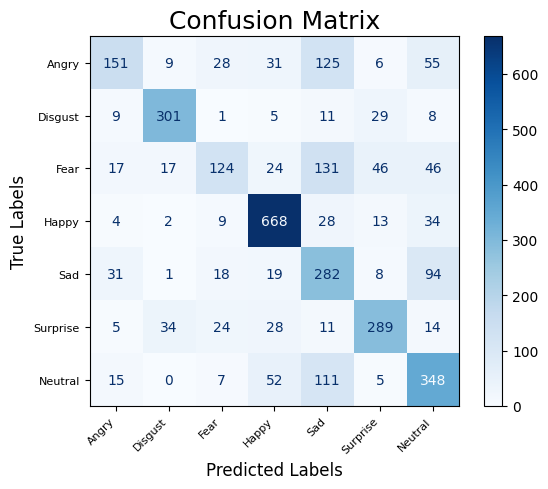

In [26]:
# Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Mengatur ukuran gambar
plt.figure(figsize=(12, 10))

# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur judul dan ukuran font
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Ukuran font lebih kecil untuk sumbu x
plt.yticks(fontsize=8)  # Ukuran font lebih kecil untuk sumbu y
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Tampilkan plot
plt.show()

In [30]:
vit_with_weights2 = ViTWithClassWeights(base_vit=vit, class_weights=class_weights)

In [31]:
# Load state_dict
model_path = "../Khaairi/Result/pretrained_best_model.pt"
vit_with_weights2.load_state_dict(torch.load(model_path))

/tmp/ipykernel_62561/2954591399.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_with_weights2.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for ViTWithClassWeights:
	Missing key(s) in state_dict: "vit.vit.embeddings.cls_token", "vit.vit.embeddings.position_embeddings", "vit.vit.embeddings.patch_embeddings.projection.weight", "vit.vit.embeddings.patch_embeddings.projection.bias", "vit.vit.encoder.layer.0.attention.attention.query.weight", "vit.vit.encoder.layer.0.attention.attention.query.bias", "vit.vit.encoder.layer.0.attention.attention.key.weight", "vit.vit.encoder.layer.0.attention.attention.key.bias", "vit.vit.encoder.layer.0.attention.attention.value.weight", "vit.vit.encoder.layer.0.attention.attention.value.bias", "vit.vit.encoder.layer.0.attention.output.dense.weight", "vit.vit.encoder.layer.0.attention.output.dense.bias", "vit.vit.encoder.layer.0.intermediate.dense.weight", "vit.vit.encoder.layer.0.intermediate.dense.bias", "vit.vit.encoder.layer.0.output.dense.weight", "vit.vit.encoder.layer.0.output.dense.bias", "vit.vit.encoder.layer.0.layernorm_before.weight", "vit.vit.encoder.layer.0.layernorm_before.bias", "vit.vit.encoder.layer.0.layernorm_after.weight", "vit.vit.encoder.layer.0.layernorm_after.bias", "vit.vit.encoder.layer.1.attention.attention.query.weight", "vit.vit.encoder.layer.1.attention.attention.query.bias", "vit.vit.encoder.layer.1.attention.attention.key.weight", "vit.vit.encoder.layer.1.attention.attention.key.bias", "vit.vit.encoder.layer.1.attention.attention.value.weight", "vit.vit.encoder.layer.1.attention.attention.value.bias", "vit.vit.encoder.layer.1.attention.output.dense.weight", "vit.vit.encoder.layer.1.attention.output.dense.bias", "vit.vit.encoder.layer.1.intermediate.dense.weight", "vit.vit.encoder.layer.1.intermediate.dense.bias", "vit.vit.encoder.layer.1.output.dense.weight", "vit.vit.encoder.layer.1.output.dense.bias", "vit.vit.encoder.layer.1.layernorm_before.weight", "vit.vit.encoder.layer.1.layernorm_before.bias", "vit.vit.encoder.layer.1.layernorm_after.weight", "vit.vit.encoder.layer.1.layernorm_after.bias", "vit.vit.encoder.layer.2.attention.attention.query.weight", "vit.vit.encoder.layer.2.attention.attention.query.bias", "vit.vit.encoder.layer.2.attention.attention.key.weight", "vit.vit.encoder.layer.2.attention.attention.key.bias", "vit.vit.encoder.layer.2.attention.attention.value.weight", "vit.vit.encoder.layer.2.attention.attention.value.bias", "vit.vit.encoder.layer.2.attention.output.dense.weight", "vit.vit.encoder.layer.2.attention.output.dense.bias", "vit.vit.encoder.layer.2.intermediate.dense.weight", "vit.vit.encoder.layer.2.intermediate.dense.bias", "vit.vit.encoder.layer.2.output.dense.weight", "vit.vit.encoder.layer.2.output.dense.bias", "vit.vit.encoder.layer.2.layernorm_before.weight", "vit.vit.encoder.layer.2.layernorm_before.bias", "vit.vit.encoder.layer.2.layernorm_after.weight", "vit.vit.encoder.layer.2.layernorm_after.bias", "vit.vit.encoder.layer.3.attention.attention.query.weight", "vit.vit.encoder.layer.3.attention.attention.query.bias", "vit.vit.encoder.layer.3.attention.attention.key.weight", "vit.vit.encoder.layer.3.attention.attention.key.bias", "vit.vit.encoder.layer.3.attention.attention.value.weight", "vit.vit.encoder.layer.3.attention.attention.value.bias", "vit.vit.encoder.layer.3.attention.output.dense.weight", "vit.vit.encoder.layer.3.attention.output.dense.bias", "vit.vit.encoder.layer.3.intermediate.dense.weight", "vit.vit.encoder.layer.3.intermediate.dense.bias", "vit.vit.encoder.layer.3.output.dense.weight", "vit.vit.encoder.layer.3.output.dense.bias", "vit.vit.encoder.layer.3.layernorm_before.weight", "vit.vit.encoder.layer.3.layernorm_before.bias", "vit.vit.encoder.layer.3.layernorm_after.weight", "vit.vit.encoder.layer.3.layernorm_after.bias", "vit.vit.encoder.layer.4.attention.attention.query.weight", "vit.vit.encoder.layer.4.attention.attention.query.bias", "vit.vit.encoder.layer.4.attention.attention.key.weight", "vit.vit.encoder.layer.4.attention.attention.key.bias", "vit.vit.encoder.layer.4.attention.attention.value.weight", "vit.vit.encoder.layer.4.attention.attention.value.bias", "vit.vit.encoder.layer.4.attention.output.dense.weight", "vit.vit.encoder.layer.4.attention.output.dense.bias", "vit.vit.encoder.layer.4.intermediate.dense.weight", "vit.vit.encoder.layer.4.intermediate.dense.bias", "vit.vit.encoder.layer.4.output.dense.weight", "vit.vit.encoder.layer.4.output.dense.bias", "vit.vit.encoder.layer.4.layernorm_before.weight", "vit.vit.encoder.layer.4.layernorm_before.bias", "vit.vit.encoder.layer.4.layernorm_after.weight", "vit.vit.encoder.layer.4.layernorm_after.bias", "vit.vit.encoder.layer.5.attention.attention.query.weight", "vit.vit.encoder.layer.5.attention.attention.query.bias", "vit.vit.encoder.layer.5.attention.attention.key.weight", "vit.vit.encoder.layer.5.attention.attention.key.bias", "vit.vit.encoder.layer.5.attention.attention.value.weight", "vit.vit.encoder.layer.5.attention.attention.value.bias", "vit.vit.encoder.layer.5.attention.output.dense.weight", "vit.vit.encoder.layer.5.attention.output.dense.bias", "vit.vit.encoder.layer.5.intermediate.dense.weight", "vit.vit.encoder.layer.5.intermediate.dense.bias", "vit.vit.encoder.layer.5.output.dense.weight", "vit.vit.encoder.layer.5.output.dense.bias", "vit.vit.encoder.layer.5.layernorm_before.weight", "vit.vit.encoder.layer.5.layernorm_before.bias", "vit.vit.encoder.layer.5.layernorm_after.weight", "vit.vit.encoder.layer.5.layernorm_after.bias", "vit.vit.encoder.layer.6.attention.attention.query.weight", "vit.vit.encoder.layer.6.attention.attention.query.bias", "vit.vit.encoder.layer.6.attention.attention.key.weight", "vit.vit.encoder.layer.6.attention.attention.key.bias", "vit.vit.encoder.layer.6.attention.attention.value.weight", "vit.vit.encoder.layer.6.attention.attention.value.bias", "vit.vit.encoder.layer.6.attention.output.dense.weight", "vit.vit.encoder.layer.6.attention.output.dense.bias", "vit.vit.encoder.layer.6.intermediate.dense.weight", "vit.vit.encoder.layer.6.intermediate.dense.bias", "vit.vit.encoder.layer.6.output.dense.weight", "vit.vit.encoder.layer.6.output.dense.bias", "vit.vit.encoder.layer.6.layernorm_before.weight", "vit.vit.encoder.layer.6.layernorm_before.bias", "vit.vit.encoder.layer.6.layernorm_after.weight", "vit.vit.encoder.layer.6.layernorm_after.bias", "vit.vit.encoder.layer.7.attention.attention.query.weight", "vit.vit.encoder.layer.7.attention.attention.query.bias", "vit.vit.encoder.layer.7.attention.attention.key.weight", "vit.vit.encoder.layer.7.attention.attention.key.bias", "vit.vit.encoder.layer.7.attention.attention.value.weight", "vit.vit.encoder.layer.7.attention.attention.value.bias", "vit.vit.encoder.layer.7.attention.output.dense.weight", "vit.vit.encoder.layer.7.attention.output.dense.bias", "vit.vit.encoder.layer.7.intermediate.dense.weight", "vit.vit.encoder.layer.7.intermediate.dense.bias", "vit.vit.encoder.layer.7.output.dense.weight", "vit.vit.encoder.layer.7.output.dense.bias", "vit.vit.encoder.layer.7.layernorm_before.weight", "vit.vit.encoder.layer.7.layernorm_before.bias", "vit.vit.encoder.layer.7.layernorm_after.weight", "vit.vit.encoder.layer.7.layernorm_after.bias", "vit.vit.encoder.layer.8.attention.attention.query.weight", "vit.vit.encoder.layer.8.attention.attention.query.bias", "vit.vit.encoder.layer.8.attention.attention.key.weight", "vit.vit.encoder.layer.8.attention.attention.key.bias", "vit.vit.encoder.layer.8.attention.attention.value.weight", "vit.vit.encoder.layer.8.attention.attention.value.bias", "vit.vit.encoder.layer.8.attention.output.dense.weight", "vit.vit.encoder.layer.8.attention.output.dense.bias", "vit.vit.encoder.layer.8.intermediate.dense.weight", "vit.vit.encoder.layer.8.intermediate.dense.bias", "vit.vit.encoder.layer.8.output.dense.weight", "vit.vit.encoder.layer.8.output.dense.bias", "vit.vit.encoder.layer.8.layernorm_before.weight", "vit.vit.encoder.layer.8.layernorm_before.bias", "vit.vit.encoder.layer.8.layernorm_after.weight", "vit.vit.encoder.layer.8.layernorm_after.bias", "vit.vit.encoder.layer.9.attention.attention.query.weight", "vit.vit.encoder.layer.9.attention.attention.query.bias", "vit.vit.encoder.layer.9.attention.attention.key.weight", "vit.vit.encoder.layer.9.attention.attention.key.bias", "vit.vit.encoder.layer.9.attention.attention.value.weight", "vit.vit.encoder.layer.9.attention.attention.value.bias", "vit.vit.encoder.layer.9.attention.output.dense.weight", "vit.vit.encoder.layer.9.attention.output.dense.bias", "vit.vit.encoder.layer.9.intermediate.dense.weight", "vit.vit.encoder.layer.9.intermediate.dense.bias", "vit.vit.encoder.layer.9.output.dense.weight", "vit.vit.encoder.layer.9.output.dense.bias", "vit.vit.encoder.layer.9.layernorm_before.weight", "vit.vit.encoder.layer.9.layernorm_before.bias", "vit.vit.encoder.layer.9.layernorm_after.weight", "vit.vit.encoder.layer.9.layernorm_after.bias", "vit.vit.encoder.layer.10.attention.attention.query.weight", "vit.vit.encoder.layer.10.attention.attention.query.bias", "vit.vit.encoder.layer.10.attention.attention.key.weight", "vit.vit.encoder.layer.10.attention.attention.key.bias", "vit.vit.encoder.layer.10.attention.attention.value.weight", "vit.vit.encoder.layer.10.attention.attention.value.bias", "vit.vit.encoder.layer.10.attention.output.dense.weight", "vit.vit.encoder.layer.10.attention.output.dense.bias", "vit.vit.encoder.layer.10.intermediate.dense.weight", "vit.vit.encoder.layer.10.intermediate.dense.bias", "vit.vit.encoder.layer.10.output.dense.weight", "vit.vit.encoder.layer.10.output.dense.bias", "vit.vit.encoder.layer.10.layernorm_before.weight", "vit.vit.encoder.layer.10.layernorm_before.bias", "vit.vit.encoder.layer.10.layernorm_after.weight", "vit.vit.encoder.layer.10.layernorm_after.bias", "vit.vit.encoder.layer.11.attention.attention.query.weight", "vit.vit.encoder.layer.11.attention.attention.query.bias", "vit.vit.encoder.layer.11.attention.attention.key.weight", "vit.vit.encoder.layer.11.attention.attention.key.bias", "vit.vit.encoder.layer.11.attention.attention.value.weight", "vit.vit.encoder.layer.11.attention.attention.value.bias", "vit.vit.encoder.layer.11.attention.output.dense.weight", "vit.vit.encoder.layer.11.attention.output.dense.bias", "vit.vit.encoder.layer.11.intermediate.dense.weight", "vit.vit.encoder.layer.11.intermediate.dense.bias", "vit.vit.encoder.layer.11.output.dense.weight", "vit.vit.encoder.layer.11.output.dense.bias", "vit.vit.encoder.layer.11.layernorm_before.weight", "vit.vit.encoder.layer.11.layernorm_before.bias", "vit.vit.encoder.layer.11.layernorm_after.weight", "vit.vit.encoder.layer.11.layernorm_after.bias", "vit.vit.layernorm.weight", "vit.vit.layernorm.bias", "vit.classifier.weight", "vit.classifier.bias", "loss_fn.weight". 
	Unexpected key(s) in state_dict: "classifier.weight", "classifier.bias", "vit.embeddings.cls_token", "vit.embeddings.position_embeddings", "vit.embeddings.patch_embeddings.projection.weight", "vit.embeddings.patch_embeddings.projection.bias", "vit.encoder.layer.0.attention.attention.query.weight", "vit.encoder.layer.0.attention.attention.query.bias", "vit.encoder.layer.0.attention.attention.key.weight", "vit.encoder.layer.0.attention.attention.key.bias", "vit.encoder.layer.0.attention.attention.value.weight", "vit.encoder.layer.0.attention.attention.value.bias", "vit.encoder.layer.0.attention.output.dense.weight", "vit.encoder.layer.0.attention.output.dense.bias", "vit.encoder.layer.0.intermediate.dense.weight", "vit.encoder.layer.0.intermediate.dense.bias", "vit.encoder.layer.0.output.dense.weight", "vit.encoder.layer.0.output.dense.bias", "vit.encoder.layer.0.layernorm_before.weight", "vit.encoder.layer.0.layernorm_before.bias", "vit.encoder.layer.0.layernorm_after.weight", "vit.encoder.layer.0.layernorm_after.bias", "vit.encoder.layer.1.attention.attention.query.weight", "vit.encoder.layer.1.attention.attention.query.bias", "vit.encoder.layer.1.attention.attention.key.weight", "vit.encoder.layer.1.attention.attention.key.bias", "vit.encoder.layer.1.attention.attention.value.weight", "vit.encoder.layer.1.attention.attention.value.bias", "vit.encoder.layer.1.attention.output.dense.weight", "vit.encoder.layer.1.attention.output.dense.bias", "vit.encoder.layer.1.intermediate.dense.weight", "vit.encoder.layer.1.intermediate.dense.bias", "vit.encoder.layer.1.output.dense.weight", "vit.encoder.layer.1.output.dense.bias", "vit.encoder.layer.1.layernorm_before.weight", "vit.encoder.layer.1.layernorm_before.bias", "vit.encoder.layer.1.layernorm_after.weight", "vit.encoder.layer.1.layernorm_after.bias", "vit.encoder.layer.2.attention.attention.query.weight", "vit.encoder.layer.2.attention.attention.query.bias", "vit.encoder.layer.2.attention.attention.key.weight", "vit.encoder.layer.2.attention.attention.key.bias", "vit.encoder.layer.2.attention.attention.value.weight", "vit.encoder.layer.2.attention.attention.value.bias", "vit.encoder.layer.2.attention.output.dense.weight", "vit.encoder.layer.2.attention.output.dense.bias", "vit.encoder.layer.2.intermediate.dense.weight", "vit.encoder.layer.2.intermediate.dense.bias", "vit.encoder.layer.2.output.dense.weight", "vit.encoder.layer.2.output.dense.bias", "vit.encoder.layer.2.layernorm_before.weight", "vit.encoder.layer.2.layernorm_before.bias", "vit.encoder.layer.2.layernorm_after.weight", "vit.encoder.layer.2.layernorm_after.bias", "vit.encoder.layer.3.attention.attention.query.weight", "vit.encoder.layer.3.attention.attention.query.bias", "vit.encoder.layer.3.attention.attention.key.weight", "vit.encoder.layer.3.attention.attention.key.bias", "vit.encoder.layer.3.attention.attention.value.weight", "vit.encoder.layer.3.attention.attention.value.bias", "vit.encoder.layer.3.attention.output.dense.weight", "vit.encoder.layer.3.attention.output.dense.bias", "vit.encoder.layer.3.intermediate.dense.weight", "vit.encoder.layer.3.intermediate.dense.bias", "vit.encoder.layer.3.output.dense.weight", "vit.encoder.layer.3.output.dense.bias", "vit.encoder.layer.3.layernorm_before.weight", "vit.encoder.layer.3.layernorm_before.bias", "vit.encoder.layer.3.layernorm_after.weight", "vit.encoder.layer.3.layernorm_after.bias", "vit.encoder.layer.4.attention.attention.query.weight", "vit.encoder.layer.4.attention.attention.query.bias", "vit.encoder.layer.4.attention.attention.key.weight", "vit.encoder.layer.4.attention.attention.key.bias", "vit.encoder.layer.4.attention.attention.value.weight", "vit.encoder.layer.4.attention.attention.value.bias", "vit.encoder.layer.4.attention.output.dense.weight", "vit.encoder.layer.4.attention.output.dense.bias", "vit.encoder.layer.4.intermediate.dense.weight", "vit.encoder.layer.4.intermediate.dense.bias", "vit.encoder.layer.4.output.dense.weight", "vit.encoder.layer.4.output.dense.bias", "vit.encoder.layer.4.layernorm_before.weight", "vit.encoder.layer.4.layernorm_before.bias", "vit.encoder.layer.4.layernorm_after.weight", "vit.encoder.layer.4.layernorm_after.bias", "vit.encoder.layer.5.attention.attention.query.weight", "vit.encoder.layer.5.attention.attention.query.bias", "vit.encoder.layer.5.attention.attention.key.weight", "vit.encoder.layer.5.attention.attention.key.bias", "vit.encoder.layer.5.attention.attention.value.weight", "vit.encoder.layer.5.attention.attention.value.bias", "vit.encoder.layer.5.attention.output.dense.weight", "vit.encoder.layer.5.attention.output.dense.bias", "vit.encoder.layer.5.intermediate.dense.weight", "vit.encoder.layer.5.intermediate.dense.bias", "vit.encoder.layer.5.output.dense.weight", "vit.encoder.layer.5.output.dense.bias", "vit.encoder.layer.5.layernorm_before.weight", "vit.encoder.layer.5.layernorm_before.bias", "vit.encoder.layer.5.layernorm_after.weight", "vit.encoder.layer.5.layernorm_after.bias", "vit.encoder.layer.6.attention.attention.query.weight", "vit.encoder.layer.6.attention.attention.query.bias", "vit.encoder.layer.6.attention.attention.key.weight", "vit.encoder.layer.6.attention.attention.key.bias", "vit.encoder.layer.6.attention.attention.value.weight", "vit.encoder.layer.6.attention.attention.value.bias", "vit.encoder.layer.6.attention.output.dense.weight", "vit.encoder.layer.6.attention.output.dense.bias", "vit.encoder.layer.6.intermediate.dense.weight", "vit.encoder.layer.6.intermediate.dense.bias", "vit.encoder.layer.6.output.dense.weight", "vit.encoder.layer.6.output.dense.bias", "vit.encoder.layer.6.layernorm_before.weight", "vit.encoder.layer.6.layernorm_before.bias", "vit.encoder.layer.6.layernorm_after.weight", "vit.encoder.layer.6.layernorm_after.bias", "vit.encoder.layer.7.attention.attention.query.weight", "vit.encoder.layer.7.attention.attention.query.bias", "vit.encoder.layer.7.attention.attention.key.weight", "vit.encoder.layer.7.attention.attention.key.bias", "vit.encoder.layer.7.attention.attention.value.weight", "vit.encoder.layer.7.attention.attention.value.bias", "vit.encoder.layer.7.attention.output.dense.weight", "vit.encoder.layer.7.attention.output.dense.bias", "vit.encoder.layer.7.intermediate.dense.weight", "vit.encoder.layer.7.intermediate.dense.bias", "vit.encoder.layer.7.output.dense.weight", "vit.encoder.layer.7.output.dense.bias", "vit.encoder.layer.7.layernorm_before.weight", "vit.encoder.layer.7.layernorm_before.bias", "vit.encoder.layer.7.layernorm_after.weight", "vit.encoder.layer.7.layernorm_after.bias", "vit.encoder.layer.8.attention.attention.query.weight", "vit.encoder.layer.8.attention.attention.query.bias", "vit.encoder.layer.8.attention.attention.key.weight", "vit.encoder.layer.8.attention.attention.key.bias", "vit.encoder.layer.8.attention.attention.value.weight", "vit.encoder.layer.8.attention.attention.value.bias", "vit.encoder.layer.8.attention.output.dense.weight", "vit.encoder.layer.8.attention.output.dense.bias", "vit.encoder.layer.8.intermediate.dense.weight", "vit.encoder.layer.8.intermediate.dense.bias", "vit.encoder.layer.8.output.dense.weight", "vit.encoder.layer.8.output.dense.bias", "vit.encoder.layer.8.layernorm_before.weight", "vit.encoder.layer.8.layernorm_before.bias", "vit.encoder.layer.8.layernorm_after.weight", "vit.encoder.layer.8.layernorm_after.bias", "vit.encoder.layer.9.attention.attention.query.weight", "vit.encoder.layer.9.attention.attention.query.bias", "vit.encoder.layer.9.attention.attention.key.weight", "vit.encoder.layer.9.attention.attention.key.bias", "vit.encoder.layer.9.attention.attention.value.weight", "vit.encoder.layer.9.attention.attention.value.bias", "vit.encoder.layer.9.attention.output.dense.weight", "vit.encoder.layer.9.attention.output.dense.bias", "vit.encoder.layer.9.intermediate.dense.weight", "vit.encoder.layer.9.intermediate.dense.bias", "vit.encoder.layer.9.output.dense.weight", "vit.encoder.layer.9.output.dense.bias", "vit.encoder.layer.9.layernorm_before.weight", "vit.encoder.layer.9.layernorm_before.bias", "vit.encoder.layer.9.layernorm_after.weight", "vit.encoder.layer.9.layernorm_after.bias", "vit.encoder.layer.10.attention.attention.query.weight", "vit.encoder.layer.10.attention.attention.query.bias", "vit.encoder.layer.10.attention.attention.key.weight", "vit.encoder.layer.10.attention.attention.key.bias", "vit.encoder.layer.10.attention.attention.value.weight", "vit.encoder.layer.10.attention.attention.value.bias", "vit.encoder.layer.10.attention.output.dense.weight", "vit.encoder.layer.10.attention.output.dense.bias", "vit.encoder.layer.10.intermediate.dense.weight", "vit.encoder.layer.10.intermediate.dense.bias", "vit.encoder.layer.10.output.dense.weight", "vit.encoder.layer.10.output.dense.bias", "vit.encoder.layer.10.layernorm_before.weight", "vit.encoder.layer.10.layernorm_before.bias", "vit.encoder.layer.10.layernorm_after.weight", "vit.encoder.layer.10.layernorm_after.bias", "vit.encoder.layer.11.attention.attention.query.weight", "vit.encoder.layer.11.attention.attention.query.bias", "vit.encoder.layer.11.attention.attention.key.weight", "vit.encoder.layer.11.attention.attention.key.bias", "vit.encoder.layer.11.attention.attention.value.weight", "vit.encoder.layer.11.attention.attention.value.bias", "vit.encoder.layer.11.attention.output.dense.weight", "vit.encoder.layer.11.attention.output.dense.bias", "vit.encoder.layer.11.intermediate.dense.weight", "vit.encoder.layer.11.intermediate.dense.bias", "vit.encoder.layer.11.output.dense.weight", "vit.encoder.layer.11.output.dense.bias", "vit.encoder.layer.11.layernorm_before.weight", "vit.encoder.layer.11.layernorm_before.bias", "vit.encoder.layer.11.layernorm_after.weight", "vit.encoder.layer.11.layernorm_after.bias", "vit.layernorm.weight", "vit.layernorm.bias". 

In [ ]:
trainer = Trainer(
    model=vit2,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,
    callbacks=[SaveBestModelCallback(save_path = '../Khaairi/Result')]
)

In [ ]:
trainer.evaluate(processed_dataset["test"])

In [ ]:
# Melakukan prediksi pada dataset validasi
predictions = trainer.predict(processed_dataset["test"])

# Mendapatkan logits dan label sebenarnya
logits = predictions.predictions
labels = predictions.label_ids

# Mendapatkan prediksi akhir dengan argmax
y_pred = np.argmax(logits, axis=1)
y_true = labels

In [ ]:
# Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Mengatur ukuran gambar
plt.figure(figsize=(12, 10))

# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur judul dan ukuran font
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Ukuran font lebih kecil untuk sumbu x
plt.yticks(fontsize=8)  # Ukuran font lebih kecil untuk sumbu y
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Tampilkan plot
plt.show()